In [1]:
trial_number_ml = "001"
random_state_init = 42

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 14:30:36,353] A new study created in memory with name: no-name-e88c5c53-1115-4eef-9a52-61b798deb4bb


[I 2024-05-01 14:30:52,685] Trial 2 finished with value: 0.7153308140066438 and parameters: {'n_estimators': 116, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.7153308140066438.


[I 2024-05-01 14:31:32,138] Trial 1 finished with value: 0.7213934517823221 and parameters: {'n_estimators': 396, 'max_depth': 83, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 0.7213934517823221.


[I 2024-05-01 14:31:38,744] Trial 0 finished with value: 0.7245786730868863 and parameters: {'n_estimators': 446, 'max_depth': 32, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7245786730868863.


[I 2024-05-01 14:31:50,116] Trial 5 finished with value: 0.7252145999045094 and parameters: {'n_estimators': 114, 'max_depth': 82, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 5 with value: 0.7252145999045094.


[I 2024-05-01 14:32:12,280] Trial 6 finished with value: 0.7319136724265788 and parameters: {'n_estimators': 191, 'max_depth': 76, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.7319136724265788.


[I 2024-05-01 14:32:14,257] Trial 3 pruned. 


[I 2024-05-01 14:32:16,006] Trial 7 pruned. 


[I 2024-05-01 14:32:20,701] Trial 10 pruned. 


[I 2024-05-01 14:33:07,984] Trial 4 finished with value: 0.7370148010443016 and parameters: {'n_estimators': 778, 'max_depth': 92, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.7370148010443016.


[I 2024-05-01 14:33:29,907] Trial 8 finished with value: 0.728088968803015 and parameters: {'n_estimators': 523, 'max_depth': 76, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 4 with value: 0.7370148010443016.


[I 2024-05-01 14:33:38,249] Trial 12 pruned. 


[I 2024-05-01 14:34:10,320] Trial 14 pruned. 


[I 2024-05-01 14:34:25,819] Trial 9 finished with value: 0.7268160993102327 and parameters: {'n_estimators': 789, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.7370148010443016.


[I 2024-05-01 14:34:37,231] Trial 11 finished with value: 0.7287259114781743 and parameters: {'n_estimators': 801, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.7370148010443016.


[I 2024-05-01 14:35:03,468] Trial 17 pruned. 


[I 2024-05-01 14:36:02,202] Trial 18 finished with value: 0.744027773545038 and parameters: {'n_estimators': 281, 'max_depth': 66, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:36:35,312] Trial 16 finished with value: 0.7376522516482288 and parameters: {'n_estimators': 607, 'max_depth': 99, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:36:35,923] Trial 15 finished with value: 0.7389276607848515 and parameters: {'n_estimators': 690, 'max_depth': 100, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:36:53,141] Trial 13 finished with value: 0.7414769552717926 and parameters: {'n_estimators': 968, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:37:41,328] Trial 21 finished with value: 0.7430743912473715 and parameters: {'n_estimators': 304, 'max_depth': 60, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:37:54,316] Trial 23 pruned. 


[I 2024-05-01 14:38:44,266] Trial 20 finished with value: 0.7392461321224312 and parameters: {'n_estimators': 605, 'max_depth': 60, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:39:20,353] Trial 19 finished with value: 0.7405190016152134 and parameters: {'n_estimators': 932, 'max_depth': 59, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:39:26,945] Trial 25 pruned. 


[I 2024-05-01 14:39:31,813] Trial 26 pruned. 


[I 2024-05-01 14:39:49,823] Trial 28 pruned. 


[I 2024-05-01 14:40:20,494] Trial 22 finished with value: 0.7395651113887788 and parameters: {'n_estimators': 971, 'max_depth': 61, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:40:23,631] Trial 27 finished with value: 0.7382891943233881 and parameters: {'n_estimators': 265, 'max_depth': 68, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:40:45,386] Trial 31 pruned. 


[I 2024-05-01 14:41:31,551] Trial 24 finished with value: 0.7424349089283719 and parameters: {'n_estimators': 998, 'max_depth': 66, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:41:37,959] Trial 29 finished with value: 0.7360578632452585 and parameters: {'n_estimators': 496, 'max_depth': 67, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:41:50,290] Trial 32 pruned. 


[I 2024-05-01 14:42:03,630] Trial 30 finished with value: 0.737332256524345 and parameters: {'n_estimators': 473, 'max_depth': 70, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:42:40,929] Trial 36 pruned. 


[I 2024-05-01 14:43:16,071] Trial 37 pruned. 


[I 2024-05-01 14:43:17,152] Trial 33 pruned. 


[I 2024-05-01 14:43:24,280] Trial 39 pruned. 


[I 2024-05-01 14:43:29,216] Trial 38 pruned. 


[I 2024-05-01 14:43:37,256] Trial 41 pruned. 


[I 2024-05-01 14:43:41,717] Trial 40 pruned. 


[I 2024-05-01 14:43:53,522] Trial 43 pruned. 


[I 2024-05-01 14:43:55,578] Trial 42 pruned. 


[I 2024-05-01 14:44:45,594] Trial 34 finished with value: 0.7398830747975904 and parameters: {'n_estimators': 860, 'max_depth': 75, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:44:51,190] Trial 35 finished with value: 0.7379702150570404 and parameters: {'n_estimators': 831, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


[I 2024-05-01 14:45:33,598] Trial 46 pruned. 


[I 2024-05-01 14:45:40,766] Trial 47 pruned. 


[I 2024-05-01 14:46:01,288] Trial 45 pruned. 


[I 2024-05-01 14:46:15,631] Trial 48 pruned. 


[I 2024-05-01 14:46:17,031] Trial 49 pruned. 


[I 2024-05-01 14:46:28,182] Trial 44 finished with value: 0.7402015461351701 and parameters: {'n_estimators': 922, 'max_depth': 58, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.744027773545038.


Best trial for RandomForestClassifier:
  Value: 0.744027773545038
  Params: 
    n_estimators: 281
    max_depth: 66
    min_samples_split: 8
    min_samples_leaf: 3
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 281, 'max_depth': 66, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


[I 2024-05-01 14:46:34,654] A new study created in memory with name: no-name-78217a37-9c0d-4f33-975e-41e6baa32584


RandomForestClassifier accuracy: 0.7210



[I 2024-05-01 14:47:32,913] Trial 1 finished with value: 0.7124660957547313 and parameters: {'n_estimators': 181, 'max_depth': 6, 'learning_rate': 0.2830953402453923, 'min_child_weight': 1, 'subsample': 0.5887926199757794, 'colsample_bytree': 0.504739447925763, 'gamma': 3.5739989814034807, 'reg_lambda': 0.15598887276567425, 'reg_alpha': 0.4189381164734037}. Best is trial 1 with value: 0.7124660957547313.


[I 2024-05-01 14:47:33,269] Trial 2 finished with value: 0.7287289590507827 and parameters: {'n_estimators': 203, 'max_depth': 4, 'learning_rate': 0.08087104228507169, 'min_child_weight': 7, 'subsample': 0.8064655684735169, 'colsample_bytree': 0.7962189754002332, 'gamma': 4.1130175464992655, 'reg_lambda': 4.566904398988674, 'reg_alpha': 0.1940591444713052}. Best is trial 2 with value: 0.7287289590507827.


[I 2024-05-01 14:47:39,340] Trial 3 finished with value: 0.7207610804660753 and parameters: {'n_estimators': 242, 'max_depth': 3, 'learning_rate': 0.03357587618374458, 'min_child_weight': 8, 'subsample': 0.5601014548715115, 'colsample_bytree': 0.9787580059414016, 'gamma': 0.5594690135950936, 'reg_lambda': 0.036585329982844715, 'reg_alpha': 0.03970740978333362}. Best is trial 2 with value: 0.7287289590507827.


[I 2024-05-01 14:47:51,804] Trial 0 finished with value: 0.7025868812157784 and parameters: {'n_estimators': 298, 'max_depth': 8, 'learning_rate': 0.29390848939946435, 'min_child_weight': 2, 'subsample': 0.5835470642608219, 'colsample_bytree': 0.5982081397760641, 'gamma': 0.7939961233976561, 'reg_lambda': 2.5711708750077378, 'reg_alpha': 0.32882122769909267}. Best is trial 2 with value: 0.7287289590507827.


[I 2024-05-01 14:47:52,630] Trial 6 finished with value: 0.7150153902416725 and parameters: {'n_estimators': 215, 'max_depth': 8, 'learning_rate': 0.2002182783985761, 'min_child_weight': 7, 'subsample': 0.5564150752273893, 'colsample_bytree': 0.9425664795942148, 'gamma': 2.839149483301133, 'reg_lambda': 2.0996672364479467, 'reg_alpha': 1.2240258716562307}. Best is trial 2 with value: 0.7287289590507827.


[I 2024-05-01 14:47:54,321] Trial 4 finished with value: 0.715983502473613 and parameters: {'n_estimators': 386, 'max_depth': 4, 'learning_rate': 0.22284986298776246, 'min_child_weight': 3, 'subsample': 0.9380117616703961, 'colsample_bytree': 0.5656520276911767, 'gamma': 3.037614501152654, 'reg_lambda': 0.014307614597772094, 'reg_alpha': 0.1514723571682154}. Best is trial 2 with value: 0.7287289590507827.


[I 2024-05-01 14:47:54,643] Trial 7 pruned. 


[I 2024-05-01 14:47:59,922] Trial 10 pruned. 


[I 2024-05-01 14:48:00,312] Trial 5 finished with value: 0.7201205822895397 and parameters: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.12856091777420336, 'min_child_weight': 8, 'subsample': 0.535707378457833, 'colsample_bytree': 0.8762049344950253, 'gamma': 3.785398981742768, 'reg_lambda': 0.5266334043151205, 'reg_alpha': 0.09072965004891989}. Best is trial 2 with value: 0.7287289590507827.


[I 2024-05-01 14:48:00,864] Trial 8 pruned. 


[I 2024-05-01 14:48:03,839] Trial 13 pruned. 


[I 2024-05-01 14:48:06,127] Trial 14 pruned. 


[I 2024-05-01 14:48:18,220] Trial 11 finished with value: 0.7178806164223529 and parameters: {'n_estimators': 212, 'max_depth': 8, 'learning_rate': 0.15779991257568035, 'min_child_weight': 9, 'subsample': 0.561330512779417, 'colsample_bytree': 0.6341415637972081, 'gamma': 2.558374990628564, 'reg_lambda': 1.200020120032531, 'reg_alpha': 0.24932484738502733}. Best is trial 2 with value: 0.7287289590507827.


[I 2024-05-01 14:48:29,726] Trial 12 finished with value: 0.7290469224595942 and parameters: {'n_estimators': 569, 'max_depth': 8, 'learning_rate': 0.07679322429148279, 'min_child_weight': 6, 'subsample': 0.8915591555770372, 'colsample_bytree': 0.5375339420615985, 'gamma': 3.3804386739637335, 'reg_lambda': 7.562359974221563, 'reg_alpha': 0.057728384159328856}. Best is trial 12 with value: 0.7290469224595942.


[I 2024-05-01 14:48:41,149] Trial 9 finished with value: 0.7335126321884619 and parameters: {'n_estimators': 697, 'max_depth': 8, 'learning_rate': 0.037389844158861124, 'min_child_weight': 2, 'subsample': 0.7792891349271761, 'colsample_bytree': 0.8972811399182494, 'gamma': 3.4168950151204665, 'reg_lambda': 0.01607314340439408, 'reg_alpha': 0.15876486299188428}. Best is trial 9 with value: 0.7335126321884619.


[I 2024-05-01 14:48:41,655] Trial 15 finished with value: 0.7277720212517396 and parameters: {'n_estimators': 754, 'max_depth': 5, 'learning_rate': 0.07881574220080369, 'min_child_weight': 5, 'subsample': 0.7549065390727369, 'colsample_bytree': 0.8323491637986155, 'gamma': 4.974961172938519, 'reg_lambda': 0.04614262627989081, 'reg_alpha': 0.04360101460481686}. Best is trial 9 with value: 0.7335126321884619.


[I 2024-05-01 14:48:43,826] Trial 17 pruned. 


[I 2024-05-01 14:48:49,669] Trial 19 pruned. 


[I 2024-05-01 14:48:53,975] Trial 16 finished with value: 0.7255386584585378 and parameters: {'n_estimators': 921, 'max_depth': 5, 'learning_rate': 0.077192394107454, 'min_child_weight': 5, 'subsample': 0.7351522739468945, 'colsample_bytree': 0.8375283861364311, 'gamma': 4.840805058719915, 'reg_lambda': 0.0812496836748294, 'reg_alpha': 0.04998966434332939}. Best is trial 9 with value: 0.7335126321884619.


[I 2024-05-01 14:48:57,745] Trial 20 pruned. 


[I 2024-05-01 14:49:01,967] Trial 22 pruned. 


[I 2024-05-01 14:49:10,204] Trial 18 finished with value: 0.7306418187913326 and parameters: {'n_estimators': 893, 'max_depth': 10, 'learning_rate': 0.08451770342147169, 'min_child_weight': 4, 'subsample': 0.8520517227765312, 'colsample_bytree': 0.656612307241631, 'gamma': 4.33361157504719, 'reg_lambda': 0.429538359820462, 'reg_alpha': 0.9002894794256698}. Best is trial 9 with value: 0.7335126321884619.


[I 2024-05-01 14:49:16,112] Trial 23 pruned. 


[I 2024-05-01 14:49:18,093] Trial 24 finished with value: 0.7312777456089558 and parameters: {'n_estimators': 325, 'max_depth': 7, 'learning_rate': 0.12649407979744082, 'min_child_weight': 7, 'subsample': 0.8015944874558621, 'colsample_bytree': 0.8020218501037164, 'gamma': 4.193869754186598, 'reg_lambda': 4.621603535903784, 'reg_alpha': 0.12117416140562673}. Best is trial 9 with value: 0.7335126321884619.


[I 2024-05-01 14:49:24,108] Trial 27 pruned. 


[I 2024-05-01 14:49:42,272] Trial 28 finished with value: 0.7312772376801877 and parameters: {'n_estimators': 331, 'max_depth': 9, 'learning_rate': 0.04773200814477217, 'min_child_weight': 4, 'subsample': 0.8197858561550222, 'colsample_bytree': 0.8223767653339498, 'gamma': 4.038493061973249, 'reg_lambda': 0.26039005796033526, 'reg_alpha': 0.41462337017812}. Best is trial 9 with value: 0.7335126321884619.


[I 2024-05-01 14:49:44,307] Trial 25 finished with value: 0.7258581456536535 and parameters: {'n_estimators': 732, 'max_depth': 9, 'learning_rate': 0.11809700519644768, 'min_child_weight': 1, 'subsample': 0.9091083600835403, 'colsample_bytree': 0.6049682837246103, 'gamma': 3.25132559297048, 'reg_lambda': 0.2270809479246297, 'reg_alpha': 0.11316491522623992}. Best is trial 9 with value: 0.7335126321884619.


[I 2024-05-01 14:49:45,524] Trial 26 finished with value: 0.7354214284988673 and parameters: {'n_estimators': 790, 'max_depth': 9, 'learning_rate': 0.11662285331956715, 'min_child_weight': 4, 'subsample': 0.9094164212303303, 'colsample_bytree': 0.6088700135486896, 'gamma': 4.108911316507708, 'reg_lambda': 0.24969812363601976, 'reg_alpha': 0.0801263295409053}. Best is trial 26 with value: 0.7354214284988673.


[I 2024-05-01 14:49:50,553] Trial 21 finished with value: 0.737653267505765 and parameters: {'n_estimators': 691, 'max_depth': 10, 'learning_rate': 0.010782407796062696, 'min_child_weight': 3, 'subsample': 0.6802791235220917, 'colsample_bytree': 0.5054206868822564, 'gamma': 3.115770774072097, 'reg_lambda': 0.12293628407011921, 'reg_alpha': 0.10315504897939869}. Best is trial 21 with value: 0.737653267505765.


[I 2024-05-01 14:49:54,191] Trial 31 finished with value: 0.7335126321884619 and parameters: {'n_estimators': 142, 'max_depth': 7, 'learning_rate': 0.16348682105432497, 'min_child_weight': 2, 'subsample': 0.7859625210905896, 'colsample_bytree': 0.8717993198563371, 'gamma': 3.8258215275710468, 'reg_lambda': 0.08032464057863592, 'reg_alpha': 0.08089513643625222}. Best is trial 21 with value: 0.737653267505765.


[I 2024-05-01 14:50:02,921] Trial 29 finished with value: 0.7341439876471724 and parameters: {'n_estimators': 322, 'max_depth': 9, 'learning_rate': 0.05101586810829267, 'min_child_weight': 4, 'subsample': 0.7753422272540902, 'colsample_bytree': 0.8196717822544909, 'gamma': 3.9668830178080414, 'reg_lambda': 0.01010560012390443, 'reg_alpha': 0.10102932474403328}. Best is trial 21 with value: 0.737653267505765.


[I 2024-05-01 14:50:04,949] Trial 30 finished with value: 0.7325516309592743 and parameters: {'n_estimators': 324, 'max_depth': 7, 'learning_rate': 0.0537208741212198, 'min_child_weight': 4, 'subsample': 0.7836640938768068, 'colsample_bytree': 0.8221955427450056, 'gamma': 3.9150435729828366, 'reg_lambda': 0.08098970901636808, 'reg_alpha': 0.46314239900055554}. Best is trial 21 with value: 0.737653267505765.


[I 2024-05-01 14:50:11,028] Trial 35 pruned. 


[I 2024-05-01 14:50:12,829] Trial 33 pruned. 


[I 2024-05-01 14:50:21,355] Trial 34 finished with value: 0.7322367151230711 and parameters: {'n_estimators': 274, 'max_depth': 9, 'learning_rate': 0.05514663792464028, 'min_child_weight': 3, 'subsample': 0.7062660470786144, 'colsample_bytree': 0.5877983897533601, 'gamma': 2.722537741446853, 'reg_lambda': 0.010443311721033478, 'reg_alpha': 0.02736942427297423}. Best is trial 21 with value: 0.737653267505765.


[I 2024-05-01 14:50:27,241] Trial 32 finished with value: 0.7309618139152165 and parameters: {'n_estimators': 725, 'max_depth': 9, 'learning_rate': 0.05763757460968042, 'min_child_weight': 2, 'subsample': 0.6880498569126151, 'colsample_bytree': 0.5855006127931605, 'gamma': 2.5858062516820857, 'reg_lambda': 0.07210818849188273, 'reg_alpha': 0.3052369522692371}. Best is trial 21 with value: 0.737653267505765.


[I 2024-05-01 14:50:27,490] Trial 37 pruned. 


[I 2024-05-01 14:50:33,037] Trial 39 pruned. 


[I 2024-05-01 14:50:34,681] Trial 40 pruned. 


[I 2024-05-01 14:50:36,033] Trial 36 pruned. 


[I 2024-05-01 14:50:39,372] Trial 43 pruned. 


[I 2024-05-01 14:50:41,776] Trial 42 pruned. 


[I 2024-05-01 14:50:43,432] Trial 45 pruned. 


[I 2024-05-01 14:50:45,074] Trial 46 pruned. 


[I 2024-05-01 14:50:47,391] Trial 47 pruned. 


[I 2024-05-01 14:50:48,020] Trial 41 pruned. 


[I 2024-05-01 14:50:48,339] Trial 44 finished with value: 0.7290403193856093 and parameters: {'n_estimators': 147, 'max_depth': 6, 'learning_rate': 0.17682432889969035, 'min_child_weight': 2, 'subsample': 0.7646451112564495, 'colsample_bytree': 0.866487677226655, 'gamma': 3.844346489000538, 'reg_lambda': 0.1199432089652483, 'reg_alpha': 0.07561281014214156}. Best is trial 21 with value: 0.737653267505765.


[I 2024-05-01 14:50:50,295] Trial 48 pruned. 


[I 2024-05-01 14:50:50,780] Trial 49 pruned. 


[I 2024-05-01 14:50:52,242] Trial 38 finished with value: 0.7405281443330388 and parameters: {'n_estimators': 533, 'max_depth': 10, 'learning_rate': 0.02636732953826081, 'min_child_weight': 2, 'subsample': 0.6508665322515885, 'colsample_bytree': 0.9314838004131555, 'gamma': 3.5353246999810817, 'reg_lambda': 0.026043012919857444, 'reg_alpha': 0.19278769488975667}. Best is trial 38 with value: 0.7405281443330388.


Best trial for XGBClassifier:
  Value: 0.7405281443330388
  Params: 
    n_estimators: 533
    max_depth: 10
    learning_rate: 0.02636732953826081
    min_child_weight: 2
    subsample: 0.6508665322515885
    colsample_bytree: 0.9314838004131555
    gamma: 3.5353246999810817
    reg_lambda: 0.026043012919857444
    reg_alpha: 0.19278769488975667

Best hyperparameters for XGBClassifier: {'n_estimators': 533, 'max_depth': 10, 'learning_rate': 0.02636732953826081, 'min_child_weight': 2, 'subsample': 0.6508665322515885, 'colsample_bytree': 0.9314838004131555, 'gamma': 3.5353246999810817, 'reg_lambda': 0.026043012919857444, 'reg_alpha': 0.19278769488975667}


[I 2024-05-01 14:52:59,261] A new study created in memory with name: no-name-846442cd-0616-482d-93a4-b5b752dd5867


XGBClassifier accuracy: 0.7248



[I 2024-05-01 14:53:00,356] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'max_depth': 8, 'learning_rate': 0.308726114568444, 'n_estimators': 471, 'min_child_weight': 0.001321881640205358, 'min_child_samples': 1803, 'subsample': 0.8376084953366385, 'colsample_bytree': 0.9526068245780762, 'reg_alpha': 1.561658730264496e-05, 'reg_lambda': 7.301832673922357e-07}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 14:53:00,522] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 38, 'max_depth': 14, 'learning_rate': 0.2916574453182329, 'n_estimators': 731, 'min_child_weight': 0.0732820540225453, 'min_child_samples': 1892, 'subsample': 0.9288203897230638, 'colsample_bytree': 0.9740425645774343, 'reg_alpha': 0.0005481566177813723, 'reg_lambda': 1.808014255005731e-10}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 14:53:01,339] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 0, 'learning_rate': 0.3327895518198953, 'n_estimators': 655, 'min_child_weight': 0.0018197825477674, 'min_child_samples': 1991, 'subsample': 0.8241025016274068, 'colsample_bytree': 0.9077168948816834, 'reg_alpha': 0.009080431890860852, 'reg_lambda': 3.0774939695666846e-07}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 14:53:01,990] Trial 2 finished with value: 0.5951568991964568 and parameters: {'boosting_type': 'goss', 'num_leaves': 69, 'max_depth': 1, 'learning_rate': 0.44340585404016053, 'n_estimators': 988, 'min_child_weight': 0.0011675051994808163, 'min_child_samples': 983, 'subsample': 0.8681194445725097, 'colsample_bytree': 0.9185177963717788, 'reg_alpha': 0.016163269455723824, 'reg_lambda': 0.0018945338927151023}. Best is trial 2 with value: 0.5951568991964568.


[I 2024-05-01 14:53:10,741] Trial 6 finished with value: 0.6346859476427025 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 6, 'learning_rate': 0.4610719023000487, 'n_estimators': 551, 'min_child_weight': 0.0037165456732676507, 'min_child_samples': 811, 'subsample': 0.9015627300585373, 'colsample_bytree': 0.9258401266308947, 'reg_alpha': 1.285733391653768e-10, 'reg_lambda': 4.989624055085634e-09}. Best is trial 6 with value: 0.6346859476427025.


[I 2024-05-01 14:53:14,129] Trial 4 finished with value: 0.5533889007405601 and parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'max_depth': 6, 'learning_rate': 0.04009718488038898, 'n_estimators': 747, 'min_child_weight': 0.010473738552062484, 'min_child_samples': 1155, 'subsample': 0.9192126238439025, 'colsample_bytree': 0.8665183959496007, 'reg_alpha': 0.44839488285126233, 'reg_lambda': 1.053764856452292e-06}. Best is trial 6 with value: 0.6346859476427025.


[I 2024-05-01 14:53:16,223] Trial 9 finished with value: 0.5600874653338617 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'max_depth': -1, 'learning_rate': 0.45946529501299016, 'n_estimators': 784, 'min_child_weight': 0.0044578944352106015, 'min_child_samples': 1199, 'subsample': 0.8737070099971812, 'colsample_bytree': 0.8312121340151876, 'reg_alpha': 5.192831355734029e-10, 'reg_lambda': 0.020967865443711597}. Best is trial 6 with value: 0.6346859476427025.


[I 2024-05-01 14:53:17,516] Trial 8 finished with value: 0.6856941862473207 and parameters: {'boosting_type': 'goss', 'num_leaves': 97, 'max_depth': 13, 'learning_rate': 0.27914381077159195, 'n_estimators': 139, 'min_child_weight': 0.005340265744031536, 'min_child_samples': 49, 'subsample': 0.8459239966121244, 'colsample_bytree': 0.8218800603424151, 'reg_alpha': 0.00019877293944493794, 'reg_lambda': 0.01235862296084878}. Best is trial 8 with value: 0.6856941862473207.


[I 2024-05-01 14:53:17,631] Trial 11 pruned. 


[I 2024-05-01 14:53:17,792] Trial 12 pruned. 


[I 2024-05-01 14:53:18,091] Trial 10 finished with value: 0.6755015796584687 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'max_depth': 1, 'learning_rate': 0.0556646191812188, 'n_estimators': 388, 'min_child_weight': 0.007122130730854997, 'min_child_samples': 324, 'subsample': 0.9651200527000611, 'colsample_bytree': 0.9351652328724473, 'reg_alpha': 2.2281046529132458e-07, 'reg_lambda': 0.00019588440769156652}. Best is trial 8 with value: 0.6856941862473207.


[I 2024-05-01 14:53:18,668] Trial 7 finished with value: 0.6324525848495007 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': 15, 'learning_rate': 0.14734676838762048, 'n_estimators': 825, 'min_child_weight': 0.003959437814705836, 'min_child_samples': 855, 'subsample': 0.9007710778939129, 'colsample_bytree': 0.9124690915887194, 'reg_alpha': 8.073685045705126e-06, 'reg_lambda': 0.22522733981267865}. Best is trial 8 with value: 0.6856941862473207.


[I 2024-05-01 14:53:23,079] Trial 14 finished with value: 0.7134291286989912 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 14, 'learning_rate': 0.18905307638855107, 'n_estimators': 135, 'min_child_weight': 0.01090881152618626, 'min_child_samples': 49, 'subsample': 0.9677337567171119, 'colsample_bytree': 0.867051216728914, 'reg_alpha': 1.669838500341669e-07, 'reg_lambda': 0.00037682629991243264}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:23,492] Trial 15 finished with value: 0.7127952335964405 and parameters: {'boosting_type': 'goss', 'num_leaves': 88, 'max_depth': 10, 'learning_rate': 0.007227986458205687, 'n_estimators': 110, 'min_child_weight': 0.014730340530530465, 'min_child_samples': 59, 'subsample': 0.9956530322432123, 'colsample_bytree': 0.8657949404892443, 'reg_alpha': 5.0851669739977546e-08, 'reg_lambda': 0.00023960896862715747}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:23,767] Trial 17 pruned. 


[I 2024-05-01 14:53:27,113] Trial 16 finished with value: 0.6943030709373318 and parameters: {'boosting_type': 'goss', 'num_leaves': 84, 'max_depth': 12, 'learning_rate': 0.22867127207423266, 'n_estimators': 101, 'min_child_weight': 0.018787581246390857, 'min_child_samples': 67, 'subsample': 0.988055745463846, 'colsample_bytree': 0.8635089903642922, 'reg_alpha': 6.672732898538265e-08, 'reg_lambda': 0.005579902115048748}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:28,609] Trial 13 finished with value: 0.7022684098781986 and parameters: {'boosting_type': 'goss', 'num_leaves': 87, 'max_depth': 15, 'learning_rate': 0.16733736185844456, 'n_estimators': 100, 'min_child_weight': 0.028357617845603693, 'min_child_samples': 20, 'subsample': 0.9804403773348349, 'colsample_bytree': 0.8704128796836281, 'reg_alpha': 7.840669677643956e-08, 'reg_lambda': 0.5639358796540089}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:29,088] Trial 19 finished with value: 0.6895336198051585 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 8, 'learning_rate': 0.09189516281439924, 'n_estimators': 260, 'min_child_weight': 0.05063548767487553, 'min_child_samples': 510, 'subsample': 0.9642558506051322, 'colsample_bytree': 0.8832627662114501, 'reg_alpha': 9.560850203551256e-09, 'reg_lambda': 0.0003794279706188993}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:30,325] Trial 20 finished with value: 0.6879397393309562 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 9, 'learning_rate': 0.08604907119939706, 'n_estimators': 285, 'min_child_weight': 0.013548956391351175, 'min_child_samples': 500, 'subsample': 0.9553931695916651, 'colsample_bytree': 0.8429561686937566, 'reg_alpha': 4.904947920244244e-09, 'reg_lambda': 0.00037541569945669475}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:30,527] Trial 3 finished with value: 0.6783632503377726 and parameters: {'boosting_type': 'goss', 'num_leaves': 97, 'max_depth': 10, 'learning_rate': 0.3033056887371959, 'n_estimators': 453, 'min_child_weight': 0.007590364148845456, 'min_child_samples': 22, 'subsample': 0.9804619111987859, 'colsample_bytree': 0.834762201660469, 'reg_alpha': 1.2562491563924713e-08, 'reg_lambda': 3.730632609258993e-08}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:31,165] Trial 18 finished with value: 0.7060870183565456 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 12, 'learning_rate': 0.21323449582146525, 'n_estimators': 236, 'min_child_weight': 0.01682448925687024, 'min_child_samples': 51, 'subsample': 0.999805318102267, 'colsample_bytree': 0.8726313378882548, 'reg_alpha': 4.181101377682365e-08, 'reg_lambda': 0.0004359925820280733}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:31,391] Trial 21 finished with value: 0.6962189782504902 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.38894289343824884, 'n_estimators': 244, 'min_child_weight': 0.011603450162759316, 'min_child_samples': 402, 'subsample': 0.9468731445911444, 'colsample_bytree': 0.8433327284601433, 'reg_alpha': 1.3397770789622804e-06, 'reg_lambda': 1.634597790611947e-05}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:32,676] Trial 23 finished with value: 0.7127855829498471 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.36089339597163916, 'n_estimators': 221, 'min_child_weight': 0.04255491683496554, 'min_child_samples': 258, 'subsample': 0.9361631664487421, 'colsample_bytree': 0.8934889956886405, 'reg_alpha': 3.09211753952036e-07, 'reg_lambda': 1.2701659277842387e-05}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:32,805] Trial 22 finished with value: 0.7080125763162974 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.3579195925400199, 'n_estimators': 209, 'min_child_weight': 0.03955496120461317, 'min_child_samples': 280, 'subsample': 0.9956576178039929, 'colsample_bytree': 0.8897044100264707, 'reg_alpha': 1.4789388115721966e-06, 'reg_lambda': 7.3739806593730006e-06}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:33,917] Trial 25 finished with value: 0.7045038043864729 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 13, 'learning_rate': 0.21581437455244493, 'n_estimators': 200, 'min_child_weight': 0.054238639305663645, 'min_child_samples': 267, 'subsample': 0.9953340292622822, 'colsample_bytree': 0.8928069405548217, 'reg_alpha': 1.3583708670683019e-06, 'reg_lambda': 3.763377095036299e-05}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:34,082] Trial 27 finished with value: 0.6882460203781021 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 3, 'learning_rate': 0.4070975753328217, 'n_estimators': 179, 'min_child_weight': 0.09179195022734805, 'min_child_samples': 677, 'subsample': 0.9235652343796084, 'colsample_bytree': 0.8961722560270187, 'reg_alpha': 1.187458665251455e-09, 'reg_lambda': 5.033486015136219e-05}. Best is trial 14 with value: 0.7134291286989912.


[I 2024-05-01 14:53:34,331] Trial 24 finished with value: 0.7134301445565274 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 12, 'learning_rate': 0.372431269914157, 'n_estimators': 217, 'min_child_weight': 0.03559865998893009, 'min_child_samples': 222, 'subsample': 0.9959959193642582, 'colsample_bytree': 0.8912132581096979, 'reg_alpha': 1.021315775421354e-06, 'reg_lambda': 1.5723496252419317e-05}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:34,783] Trial 30 pruned. 


[I 2024-05-01 14:53:34,914] Trial 26 finished with value: 0.7073720781397617 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'max_depth': 4, 'learning_rate': 0.36131365241098273, 'n_estimators': 183, 'min_child_weight': 0.0378027562756441, 'min_child_samples': 267, 'subsample': 0.9342774022791079, 'colsample_bytree': 0.8932767211384336, 'reg_alpha': 1.529416417686091e-06, 'reg_lambda': 4.342993066341435e-06}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:35,078] Trial 28 pruned. 


[I 2024-05-01 14:53:35,424] Trial 29 pruned. 


[I 2024-05-01 14:53:36,348] Trial 32 pruned. 


[I 2024-05-01 14:53:38,792] Trial 35 finished with value: 0.7099173091965583 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.26933152488291145, 'n_estimators': 163, 'min_child_weight': 0.059132051720807426, 'min_child_samples': 189, 'subsample': 0.9571817955736948, 'colsample_bytree': 0.8787640363010982, 'reg_alpha': 7.999089512209146e-05, 'reg_lambda': 0.0019017475283826584}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:39,476] Trial 31 finished with value: 0.7111962738345574 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 11, 'learning_rate': 0.2465605943311271, 'n_estimators': 416, 'min_child_weight': 0.007901219394903273, 'min_child_samples': 227, 'subsample': 0.9751972605199272, 'colsample_bytree': 0.8028022159797696, 'reg_alpha': 2.2051274504874007e-09, 'reg_lambda': 0.04188899880483677}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:40,827] Trial 34 finished with value: 0.7060946372880668 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 7, 'learning_rate': 0.26405012274414696, 'n_estimators': 439, 'min_child_weight': 0.05578187335459955, 'min_child_samples': 177, 'subsample': 0.9530315747697156, 'colsample_bytree': 0.8785784991335633, 'reg_alpha': 8.161196349357309e-06, 'reg_lambda': 9.234782344237436e-08}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:40,996] Trial 33 finished with value: 0.6904773514562318 and parameters: {'boosting_type': 'goss', 'num_leaves': 48, 'max_depth': 8, 'learning_rate': 0.25626571600266723, 'n_estimators': 406, 'min_child_weight': 0.008038961163179885, 'min_child_samples': 160, 'subsample': 0.8046275625639526, 'colsample_bytree': 0.9589364973085253, 'reg_alpha': 1.0342825022983973e-05, 'reg_lambda': 0.0658863040077252}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:42,428] Trial 38 pruned. 


[I 2024-05-01 14:53:42,799] Trial 40 pruned. 


[I 2024-05-01 14:53:42,918] Trial 36 finished with value: 0.6949395056837229 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 14, 'learning_rate': 0.31480364962377516, 'n_estimators': 546, 'min_child_weight': 0.014135128121609063, 'min_child_samples': 383, 'subsample': 0.9819204580765648, 'colsample_bytree': 0.9918810772486978, 'reg_alpha': 2.3045191322871097e-07, 'reg_lambda': 0.0011765107742820577}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:43,814] Trial 37 finished with value: 0.6965359258017656 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.32950494708996203, 'n_estimators': 546, 'min_child_weight': 0.023013416143419955, 'min_child_samples': 393, 'subsample': 0.9436665138756067, 'colsample_bytree': 0.989389402072455, 'reg_alpha': 2.409906582172878e-07, 'reg_lambda': 0.003236242665355317}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:44,090] Trial 42 pruned. 


[I 2024-05-01 14:53:45,221] Trial 39 finished with value: 0.6981287904184317 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 14, 'learning_rate': 0.32175880307719606, 'n_estimators': 530, 'min_child_weight': 0.014483542627166567, 'min_child_samples': 386, 'subsample': 0.9841156518118956, 'colsample_bytree': 0.9026521531990301, 'reg_alpha': 2.5242508278404805e-07, 'reg_lambda': 0.002248250030571846}. Best is trial 24 with value: 0.7134301445565274.


[I 2024-05-01 14:53:46,464] Trial 43 pruned. 


[I 2024-05-01 14:53:47,442] Trial 44 finished with value: 0.7150235171019617 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 11, 'learning_rate': 0.29862380974947444, 'n_estimators': 158, 'min_child_weight': 0.005390750592545356, 'min_child_samples': 118, 'subsample': 0.9774029720082996, 'colsample_bytree': 0.9086087035791648, 'reg_alpha': 7.351736017675398e-10, 'reg_lambda': 6.175767584830892e-07}. Best is trial 44 with value: 0.7150235171019617.


[I 2024-05-01 14:53:48,847] Trial 41 pruned. 


[I 2024-05-01 14:53:50,021] Trial 46 finished with value: 0.7099188329828625 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 11, 'learning_rate': 0.28865459869835214, 'n_estimators': 154, 'min_child_weight': 0.009728509715347635, 'min_child_samples': 114, 'subsample': 0.9641049204516898, 'colsample_bytree': 0.8075139156292765, 'reg_alpha': 3.147502269137979e-10, 'reg_lambda': 0.056290715903582186}. Best is trial 44 with value: 0.7150235171019617.


[I 2024-05-01 14:53:50,737] Trial 47 finished with value: 0.716617905504932 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.290634979295979, 'n_estimators': 144, 'min_child_weight': 0.005441735943022486, 'min_child_samples': 121, 'subsample': 0.9630555051478193, 'colsample_bytree': 0.9283340036479161, 'reg_alpha': 1.322641325196879e-10, 'reg_lambda': 9.016122911026952e-07}. Best is trial 47 with value: 0.716617905504932.


[I 2024-05-01 14:53:50,893] Trial 49 pruned. 


[I 2024-05-01 14:53:52,269] Trial 48 finished with value: 0.7051366836314875 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 11, 'learning_rate': 0.2867923415631839, 'n_estimators': 145, 'min_child_weight': 0.005753263067464741, 'min_child_samples': 101, 'subsample': 0.8889059921354109, 'colsample_bytree': 0.9351796961367584, 'reg_alpha': 1.6872393695699695e-10, 'reg_lambda': 1.81713463774971e-08}. Best is trial 47 with value: 0.716617905504932.


[I 2024-05-01 14:53:55,351] Trial 45 finished with value: 0.7092829061652394 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 11, 'learning_rate': 0.1369255788556163, 'n_estimators': 668, 'min_child_weight': 0.006340816449499048, 'min_child_samples': 123, 'subsample': 0.9609791065005772, 'colsample_bytree': 0.8142153110698923, 'reg_alpha': 3.6565355506841243e-10, 'reg_lambda': 6.189383239114495e-07}. Best is trial 47 with value: 0.716617905504932.


Best trial for LGBMClassifier:
  Value: 0.716617905504932
  Params: 
    boosting_type: gbdt
    num_leaves: 42
    max_depth: 12
    learning_rate: 0.290634979295979
    n_estimators: 144
    min_child_weight: 0.005441735943022486
    min_child_samples: 121
    subsample: 0.9630555051478193
    colsample_bytree: 0.9283340036479161
    reg_alpha: 1.322641325196879e-10
    reg_lambda: 9.016122911026952e-07

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.290634979295979, 'n_estimators': 144, 'min_child_weight': 0.005441735943022486, 'min_child_samples': 121, 'subsample': 0.9630555051478193, 'colsample_bytree': 0.9283340036479161, 'reg_alpha': 1.322641325196879e-10, 'reg_lambda': 9.016122911026952e-07}


LGBMClassifier accuracy: 0.7223
LGBMClassifier accuracy: 0.7223



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_001/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

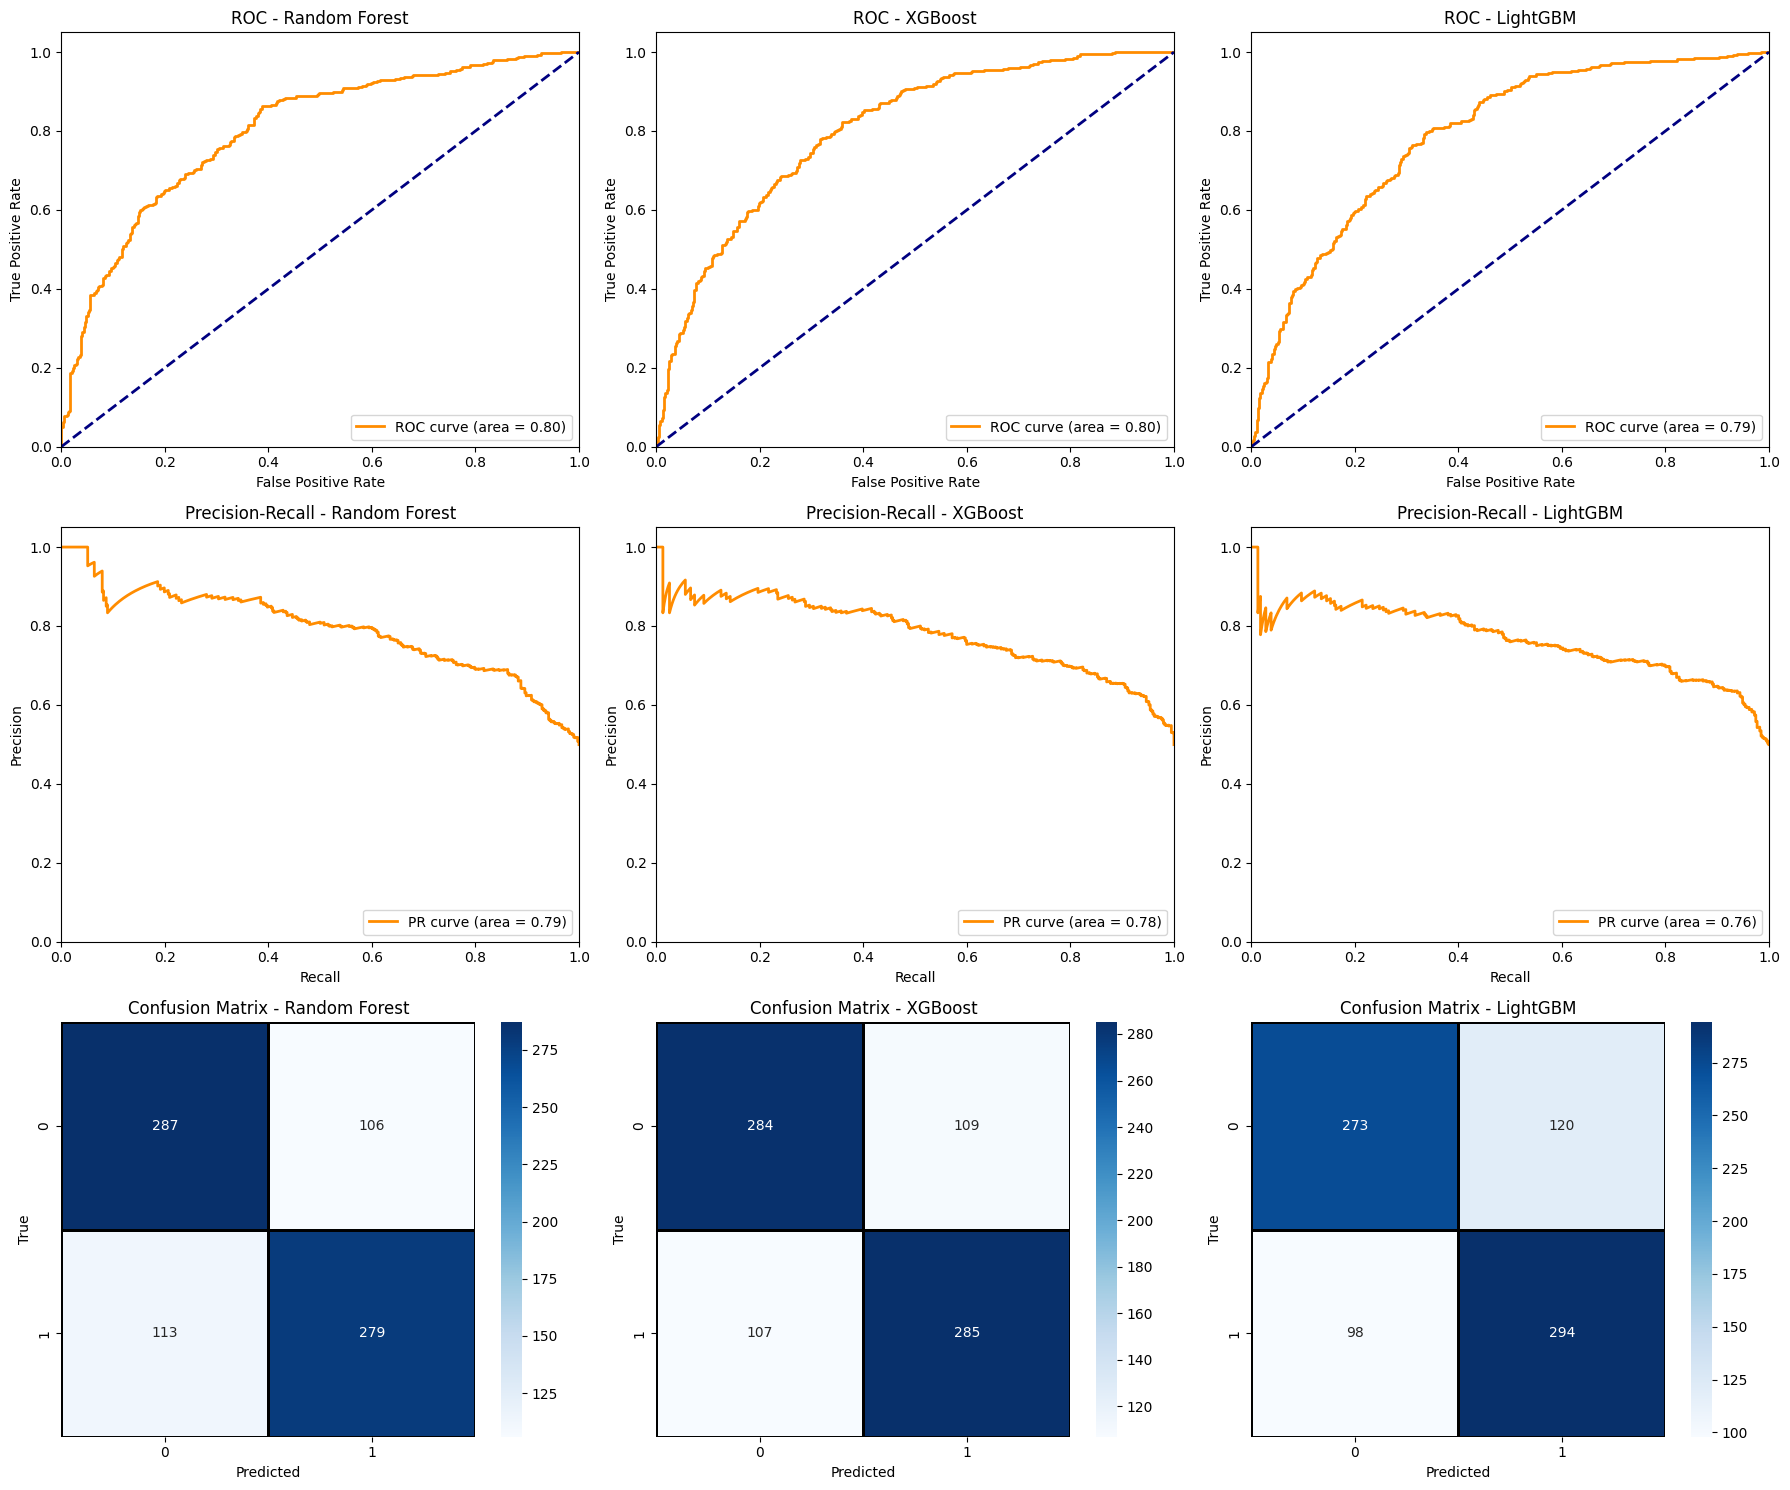

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7210191082802547, 'Precision': 0.7246753246753247, 'Recall': 0.7117346938775511, 'F1 Score': 0.7181467181467183, 'ROC AUC': 0.8002544529262087}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7248407643312101, 'Precision': 0.7233502538071066, 'Recall': 0.7270408163265306, 'F1 Score': 0.7251908396946565, 'ROC AUC': 0.8032598535597444}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7222929936305732, 'Precision': 0.7101449275362319, 'Recall': 0.75, 'F1 Score': 0.7295285359801489, 'ROC AUC': 0.7919133302175834}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7222929936305732,
 'Precision': 0.7101449275362319,
 'Recall': 0.75,
 'F1 Score': 0.7295285359801489,
 'ROC AUC': 0.7919133302175834}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: XGBoost with Accuracy: 0.7248


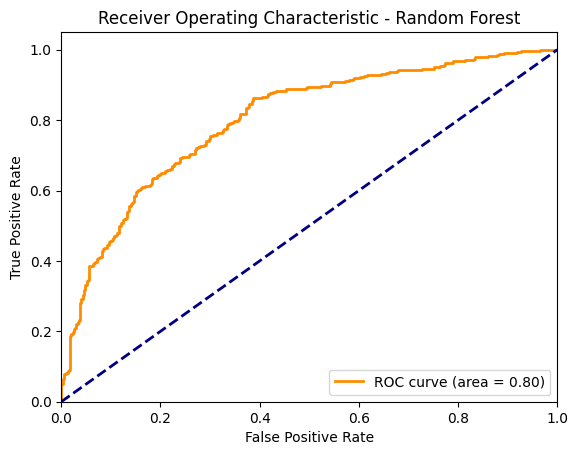

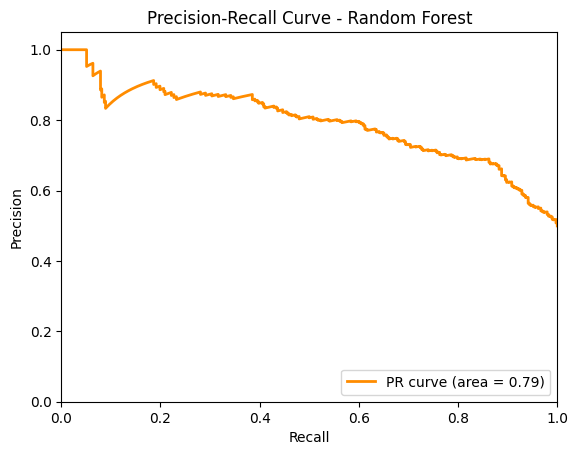

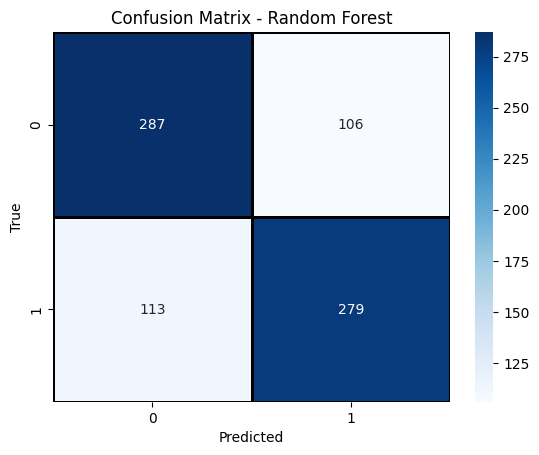

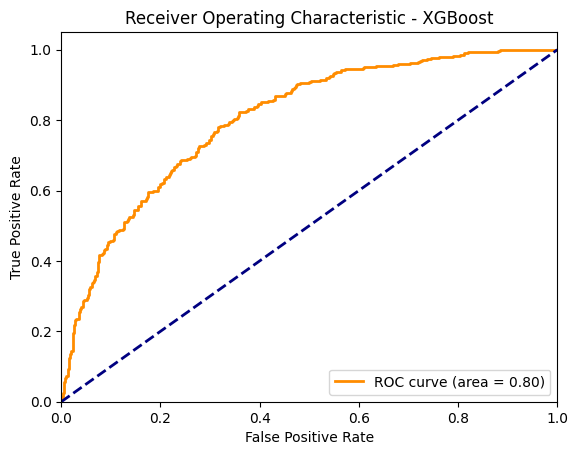

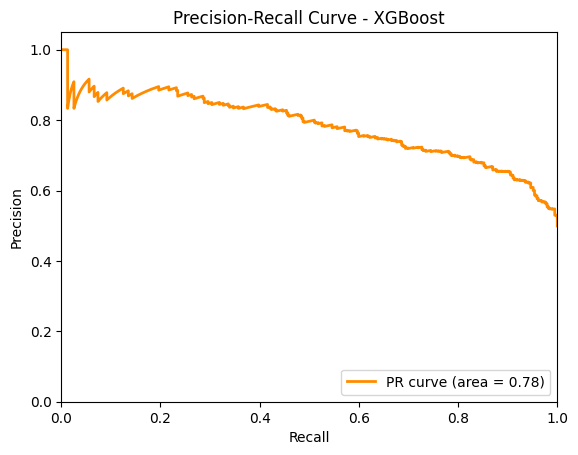

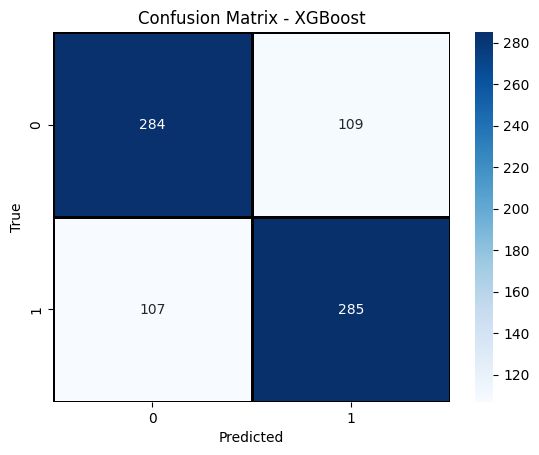

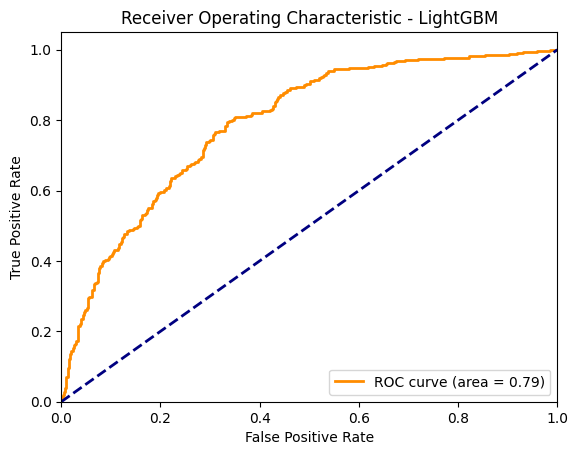

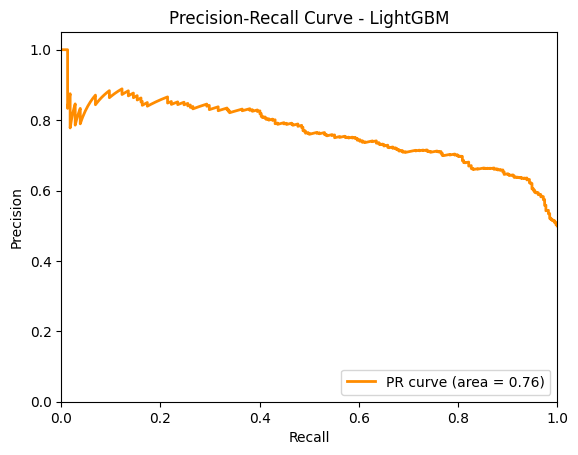

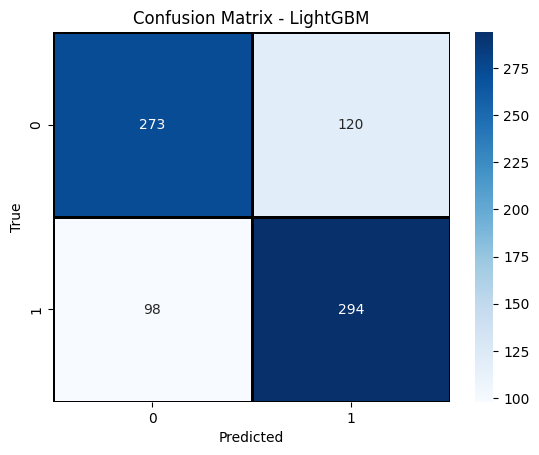

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

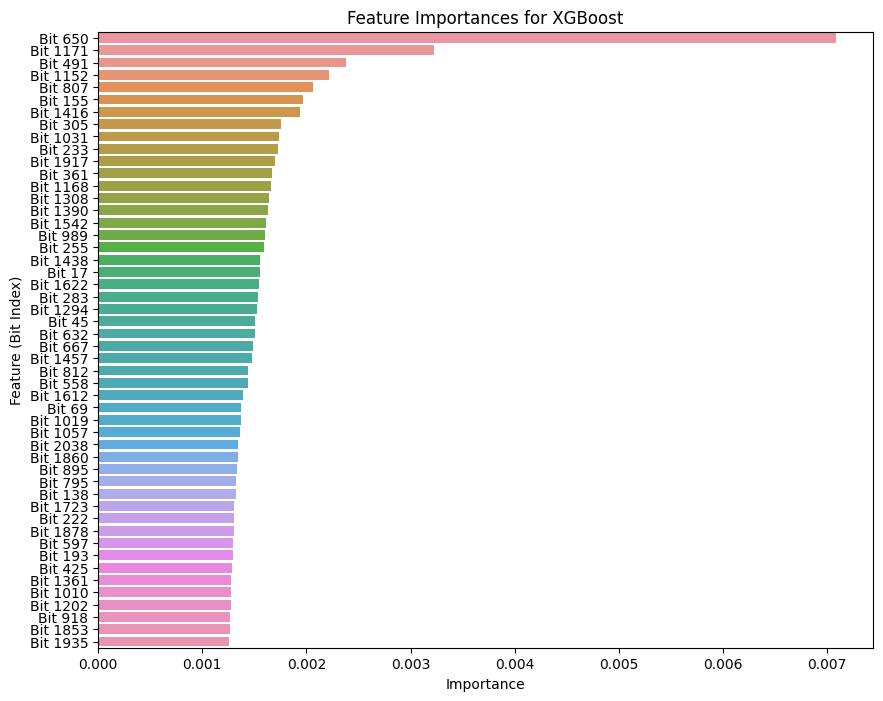

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
